# Vehicle Detection

## Part 1: Bounding Boxes

The first step is to be able to identify the vehicles. This is done with bounding boxes.

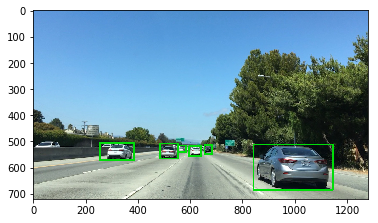

In [12]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline

#In part one of feature extraction we will draw bounding boxes:

image = mpimg.imread('bbox-eg.jpg')

def draw_boxes(img, bboxes, color=(0, 220, 10), thick=5):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    for i in range(len(bboxes)):
        cv2.rectangle(draw_img, bboxes[i][0], bboxes[i][1],color, thick)
    return draw_img # Change this line to return image copy with boxes
# Add bounding boxes in this format, these are just example coordinates.
#bboxes = [((100, 100), (200, 200)), ((300, 300), (400, 400))]
bboxes = [((255,505), (385, 572)), ((484,508), (552, 565)), ((555,516), (583, 542)),\
 ((595,519), (643, 556)),((655,514), (685, 547)), ((842,512), (1146, 684))]

result = draw_boxes(image, bboxes)
plt.imshow(result)

## Part 2: Feature extraction

#### Pattern Matching
Although a combination of features (shape and color) would allow for the best results in many situations, in this exercise it is not the best method for realiably identifying cars. This is because the shape of the vehicle changes as the distance and orientation in relation to the dashboard camera changes. Pattern matching is **not** robust to these changes in dimension, shape and orientation. 

#### Histogram of color
The histogram of color (in RGB color space) does not identify vehicles in a color independent manner. It can identify vehicles in this space, but can get very complicated very quickly.  
 
#### Histogram of Gradients
Instead, a histogram of gradients (HOG) is used, to obtain a 'signature' for each individual image. This is robust to both color, and varying size and orientation. The HOG is carried out under a particular color space, and flattened, using np.ravel(). 
The flattened images are used to build the datasets with the label of either 'car' or 'not car'. 
